# Biomedical Data Science: Mining and Modeling (Spring 2025) - Assignment 2
### CBB & CPSC & S&DS (programming) Assignment
Due: Apr 30th, 11:59pm EST
#### Name:  write your name here (double click to edit)

## Instructions

* You only need to write code with the `TODO` comments. 
* You may write code outside of these blocks, but it will not be graded.
* If you make use of any online resource please cite the source in the code comments. 
* You may use some small utility functions directly, but notice that directly copying large chunks of codes (even with variable name replacement) are not allowed and will be considered as plagrism.
* After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook.
* After you are finished, turn in the .ipynb file to canvas. 

## Part 1: Calculating dihedral angles of proteins

## 1.1 (20 pts) 
Ramachandran plots allow us to investigate the sterically allowed and disallowed backbone
dihedral angle combinations φ and ψ in proteins. Using the file core_THR_residues.txt provided,
produce a Ramachandran plot for threonine residues. The file core_THR_residues.txt contains atomic coordinates for 
1000 threonine dipeptides taken from a database of high-resolution protein crystal structures. The
Cα, carboxyl carbon, and oxygen atoms on the prior amino acid are labelled pCa, pC, and pO. The N,
Cα and H atoms on the subsequent amino acid are labeled: nN, nCa and nH. Using this file, calculate
φ and ψ for each residue and produce a Ramachandran plot similar to that shown in below. See the
lecture notes for definitions of φ and ψ. 

In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt

core_THR_residues_URL = 'http://files2.gersteinlab.org/public-docs/2021/04.28/core_THR_residues.txt'
core_THR_residues = requests.get(core_THR_residues_URL).text.splitlines()
core_THR_residues = np.loadtxt(core_THR_residues, dtype= str)
np.set_printoptions(threshold=40)

core_THR_residues

array([['1', 'pCA', '0.796000', '-4.634000', '-35.564999'],
       ['1', 'pC', '1.707000', '-5.823000', '-35.827999'],
       ['1', 'pO', '1.546000', '-6.572000', '-36.794998'],
       ...,
       ['1000', 'nN', '-9.844000', '-788.841980', '-20.346001'],
       ['1000', 'nCA', '-11.077000', '-788.564026', '-19.641001'],
       ['1000', 'nH', '-9.906000', '-788.838989', '-21.204000']],
      dtype='<U11')

In [ ]:
def calculate_backbone_dihedrals(data):
  # TODO

  # replace this code, add comments:
  phi = np.random.uniform(-180,180, 100) 
  psi = np.random.uniform(-180,180, 100)

  # END CODE HERE
  return phi, psi


phi, psi = calculate_backbone_dihedrals(core_THR_residues)

plt.xticks(np.arange(-180, 181, step=60))
plt.yticks(np.arange(-180, 181, step=60))
plt.xlabel('$\phi$')
plt.ylabel('$\psi$')
_ = plt.scatter(phi, psi, s = 20, facecolors='none', edgecolors='k')

**Expected Output:**

![](https://files.gersteinlab.org/public-docs/2025/04.03/hw2_img1.png)

## 1.2 (20 pts) 
In the lecture notes, we not only discussed backbone dihedral angles φ and ψ, but we also discussed sidechain dihedral angles. As the side chains have different numbers of atoms, they can have different numbers of sidechain dihedral angles. In the case of threonine, there is only one sidechain dihedral angle χ1. Generate the observed side chain dihedral angle distribution from core_THR_residues.txt discussed in question 1. The observed distribution should be similar to that shown in below. See the lecture notes for the definition of χ1 in threonine.

In [ ]:
def calculate_threonine_dihedrals(data):
  # TODO

  # replace this code, add comments:
  chi = np.random.uniform(0,360, 10000)

  # END CODE HERE
  return chi

chi = calculate_threonine_dihedrals(core_THR_residues)
values, binedges = np.histogram(chi, bins = 60, density = True)
x = 0.5*(binedges[:-1] + binedges[1:])

plt.xticks(np.arange(0, 361, step=60))
plt.xlabel('$\chi_1(\circ)$')
plt.ylabel('$P(\chi_1)$')
_ = plt.plot(x, values, 'k')

**Expected Output:**

![](https://files.gersteinlab.org/public-docs/2025/04.03/hw2_img2.png)

## Part 2: Variational Autoencoder on DermaMNIST

### Introduction

A **Variational Autoencoder (VAE)** is a generative model that, like a standard autoencoder, consists of an **encoder** and a **decoder** network. The encoder $q_{\phi}(z|x)$ takes an input (such as an image) and maps it into a **latent space** – instead of producing a single latent vector, it produces a **probability distribution** (typically a Gaussian with parameters $\mu$ and $\sigma$) that represents the encoding of the input. The decoder $p_{\theta}(x|z)$ then takes a sample $z$ from this latent distribution and tries to **reconstruct** the original input. The latent space is a compressed, abstract representation of the data where similar inputs are expected to lie close together. In a VAE, this latent space is **continuous and probabilistic**, which allows us not only to reconstruct inputs but also to generate **new** data by sampling from the latent space.  

**Key components of a VAE:**

- **Encoder ($x \to z$):** The encoder network transforms an input $x$ into the parameters of a distribution over the latent variable $z$. Commonly, it outputs a vector of means $\mu$ and a vector of (log) variances $\log\sigma^2$ for a Gaussian distribution $q_{\phi}(z|x) = \mathcal{N}(z;\mu(x), \mathrm{diag}(\sigma^2(x)))$. This distribution reflects uncertainty about how $x$ is represented in latent space.

- **Latent space & reparameterization:** Instead of directly sampling $z \sim \mathcal{N}(\mu, \sigma^2)$ inside the network (which would break backpropagation due to the random sampling), VAEs use the **reparameterization trick**. We sample an auxiliary noise $\epsilon \sim \mathcal{N}(0, I)$ and then **reparameterize** as 
  $$z = \mu + \sigma \odot \epsilon,$$ 
  where $\sigma = \exp(0.5 \cdot \log\sigma^2)$ and $\odot$ is elementwise multiplication. This way, $\mu$ and $\sigma$ are treated as deterministic outputs of the encoder, and the randomness is pushed to $\epsilon$, which is independent of the network parameters. This trick allows gradients to flow through $z$ via $\mu$ and $\sigma$ during training.

- **Decoder ($z \to \hat{x}$):** The decoder network takes a latent sample $z$ and produces a reconstruction $\hat{x}$ in the original data space. The decoder is trained to make $\hat{x}$ as close as possible to the original $x$. In a generative sense, if we sample $z$ from the latent prior (often a standard Normal $\mathcal{N}(0,I)$), the decoder can generate *new* samples that resemble the training data.

- **Loss function (ELBO):** VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the data log-likelihood. In practice, this corresponds to minimizing a loss that has two terms: a **reconstruction loss** and a **KL divergence** loss. The reconstruction loss ensures the decoded output $\hat{x}$ is similar to the input $x$ (for example, using binary cross-entropy or mean squared error between $x$ and $\hat{x}$). The **KL divergence** term $D_{\mathrm{KL}}(q_{\phi}(z|x)\,\|\,p(z))$ acts as a regularizer, pushing the encoder’s output distribution $q_{\phi}(z|x)$ to be close to the chosen prior $p(z)$ (usually $p(z) = \mathcal{N}(0,I)$). The KL term effectively encourages the latent space to be well-organized and prevents the encoder from just memorizing the inputs. Mathematically, for one data point $x$, the loss (to minimize) can be written as:  
  $$\mathcal{L}(x) = \underbrace{\mathbb{E}_{q_{\phi}(z|x)}[-\log p_{\theta}(x|z)]}_{\text{Reconstruction Loss}} \;+\; \underbrace{D_{\mathrm{KL}}\!\big(q_{\phi}(z|x)\,\|\,p(z)\big)}_{\text{KL Divergence}}.$$  
  In simpler terms, we want $\hat{x}$ to be accurate (low reconstruction error) while keeping the latent $z$ distributions close to $N(0,I)$ (via a low KL divergence). Balancing these two forces prevents overfitting and yields a model that can generate realistic new data.

**Conditional VAE (CVAE):** 

In a *conditional* VAE, we incorporate additional information (like a class label $y$) into the encoder and decoder. This means the encoder learns $q(z|x,y)$ and the decoder learns $p(x|z,y)$. In practice, we feed the class label into both networks (for example, by concatenating a one-hot encoded label to the input or latent vector). By doing so, the VAE learns a latent space that is structured *per class*, and we can generate new examples conditioned on a specific class. In this assignment, we will implement a **conditional VAE on the DermaMNIST dataset**, conditioning on the disease label for each dermatoscopic image. DermaMNIST is a part of the MedMNIST collection of medical image datasets and contains 28×28 skin lesion images categorized into 7 classes of skin diseases (derived from the HAM10000 dataset). 

### Assignment Overview

In this assignment, you will build and train a conditional VAE on the **DermaMNIST** dataset using PyTorch. We will proceed through the following steps:
1. **Data Loading and Preprocessing:** Use the MedMNIST API to load DermaMNIST and prepare data loaders with appropriate transformations.
2. **Implementing the VAE Architecture:** Define the encoder and decoder networks for a conditional VAE. The architecture will incorporate image data and condition on class labels.
3. **Training Loop:** Train the VAE using the reconstruction + KL divergence loss. Implement the forward pass, reparameterization, loss computation, and backpropagation.
4. **Latent Space Visualization:** Use UMAP to project the learned latent space to 2D and visualize how the data clusters by class in the latent space.
5. (**Bonus:** *optional*) **Generation of New Samples:** Sample random latent vectors and pass them through the decoder to generate new skin lesion images for a given condition (class label).

Throughout the notebook, **fill in the code where indicated** (look for comments like `TODO` or blank placeholders). Short descriptions are provided to guide you for each part.

## 2.1: Data Loading and Preprocessing (5 pts)

In this section, we will load the DermaMNIST dataset and prepare it for training our VAE. DermaMNIST contains 28×28 color images of skin lesions across 7 classes. We will use the `medmnist` package to download and load the dataset easily. The tasks are:
1. **Define a transformation pipeline** for the images. At minimum, convert images to PyTorch tensors (and optionally normalize the pixel values).
2. **Load the DermaMNIST dataset** for training, validation, and testing splits using the provided MedMNIST classes.
3. **Create DataLoader objects** for each split to enable batching during training and evaluation.

*Hint:* Use `medmnist.DermaMNIST` class with the `split` argument as `'train'`, `'val'`, or `'test'`. The dataset returns images (as PIL images or arrays) and their labels. You can specify `transform=...` to apply the transformations defined. You might need to `pip install medmnist` if it's not already available.

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# 1. Define image transformations: convert images to tensor and (optionally) normalize.
# TODO
transform = 

# 2. Load the DermaMNIST dataset for train, val, and test splits.
# If medmnist is not installed, install it via pip: !pip install medmnist
from medmnist import DermaMNIST

batch_size = 128  # feel free to adjust batch size
download = True  # download dataset if not already downloaded

train_dataset = DermaMNIST(split='train', transform=transform, download=download)
val_dataset   = DermaMNIST(split='val',   transform=transform, download=download)
test_dataset  = DermaMNIST(split='test',  transform=transform, download=download)

# 3. Create DataLoader for each split.
# TODO

# 4. Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using downloaded and verified file: /home/cz357/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/cz357/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/cz357/.medmnist/dermamnist.npz


In [2]:
# Quick sanity check: get one batch
images, labels = next(iter(train_loader))
print(f"Batch of images shape: {images.shape}")   # expected: (batch_size, 3, 28, 28)
print(f"Batch of labels shape: {labels.shape}")   # expected: (batch_size,)  labels are class indices 0-6
print(f"Unique labels in this batch: {labels.unique().tolist()}")

Batch of images shape: torch.Size([128, 3, 28, 28])
Batch of labels shape: torch.Size([128, 1])
Unique labels in this batch: [0, 1, 2, 3, 4, 5, 6]


## 2.2: Implementing the Encoder and Decoder (20 pts)
Now, let's build the neural network architecture for our conditional VAE. We will create two modules: an **Encoder** that takes an image (and condition label) as input and produces the latent distribution parameters, and a **Decoder** that takes a latent vector (and condition label) and reconstructs the image. Because this is a *conditional* VAE, we need to incorporate the class label $y$ at both stages:
- In the **Encoder**, $y$ can be included by concatenating a one-hot representation of $y$ with the image features before the final layers that produce $\mu$ and $\log\sigma^2$.
- In the **Decoder**, $y$ can be included by concat enating a one-hot $y$ with $z$ before the first decoding layer.

We will use a simple convolutional neural network (CNN) architecture for both encoder and decoder (since the images are 28×28, we can also use fully-connected layers, but CNN will better capture spatial structure). Parts of the architecture are given, and you will fill in the missing pieces.

**Encoder Architecture (example):** A possible design is:
- Convolutional layers to encode the 28×28×3 image into a smaller feature map.
- Flatten and concatenate with the label’s one-hot vector.
- Two linear layers to output `mu` and `log_var` (each of dimension `latent_dim`).

**Decoder Architecture (example):** A reverse process:
- Take the sampled latent vector and concatenate with label one-hot.
- A linear layer to expand into a feature map shape.
- Transposed convolution (or upsampling + conv) layers to reconstruct the image from the latent features.
- The final layer should produce 3×28×28 output (the reconstructed image), likely followed by a sigmoid activation (to bound pixel values between 0 and 1).

Complete the code below by filling in the `TODO` sections for the encoder and decoder implementation.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

latent_dim = 128        # Dimensionality of the latent space (you can adjust, e.g., 16 or 32)
num_classes = 7        # DermaMNIST has 7 classes
img_channels = 3       # RGB images

class Encoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Encoder, self).__init__()
        # TODO
        # Convolutional encoder

        
        # Linear layers for mean and log-variance, taking into account label conditioning
        self.fc_mu = 
        self.fc_logvar = 
    
    def forward(self, x, y):
        # TODO


        
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Decoder, self).__init__()
        # TODO
        # Linear layer to expand z (with label) into a feature map

        # Transposed conv layers to upscale to 28x28

    def forward(self, z, y):
        # TODO



        
        return recon_x

In [9]:
# Instantiate encoder and decoder
encoder = Encoder(latent_dim, num_classes).to(device)
decoder = Decoder(latent_dim, num_classes).to(device)

# Test the encoder and decoder with a dummy input
x_sample, y_sample = images[0:2].to(device), labels[0:2].to(device) # take a couple of examples from the earlier batch
mu, log_var = encoder(x_sample, y_sample)
print("Encoder output shapes:", mu.shape, log_var.shape)  # each [2, latent_dim]
z_sample = torch.randn_like(mu)  # a random latent vector (for testing decoder)
x_recon = decoder(z_sample, y_sample)
print("Decoder output shape:", x_recon.shape)  # expected [2, 3, 28, 28]

Encoder output shapes: torch.Size([2, 128]) torch.Size([2, 128])
Decoder output shape: torch.Size([2, 3, 28, 28])


## 2.3: Training the VAE (20 pts)

Now that we have our encoder and decoder, the next step is to train the VAE. In training, we will:
- Iterate over batches of training data.
- For each batch, **encode** the images to get $\mu$ and $\log\sigma^2$.
- **Sample** a latent vector $z$ using the reparameterization trick.
- **Decode** $z$ to get reconstructed images.
- Compute the **loss**: sum of reconstruction loss and KL divergence loss.
- Backpropagate and update the model parameters.

The KL divergence term for a single data point is given by:  
$$D_{\mathrm{KL}}(q(z|x) \parallel p(z)) = -\frac{1}{2} \sum_{j=1}^{d} \Big(1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2 \Big),$$  
where $d$ is the latent dimension. We will implement this formula.

Fill in the code below to complete the training loop. Look for places marked `TODO`:
- Implement the reparameterization to obtain `z` from `mu` and `log_var`.
- Compute the `recon_loss`.
- Compute the `kl_loss` using the formula above.
- Sum the losses to get `total_loss` and perform backpropagation.

In [ ]:
import torch.optim as optim
# TODO
# Optimizer
optimizer = 

# Training parameters (feel free to adjust)
num_epochs = 200
beta = 0.001

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Encode
        mu, log_var = encoder(images, labels)
        # Reparameterization: sample z from N(mu, sigma^2)
        # TODO: implement reparameterization trick

        # TODO
        # Compute reconstruction loss

        # Compute KL divergence loss

        # Total VAE loss
   
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    # Report average loss for the epoch (feel free to adjust)
    avg_loss = train_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

After training for several epochs, you should observe the loss decreasing. During training, you might also consider monitoring the separate components of the loss (e.g., print `recon_loss.item()` and `kl_loss.item()` averages) to see the balance between reconstruction and KL. Over time, the encoder will learn to encode meaningful latent distributions and the KL term will balance with reconstruction quality.

## 2.4 Evaluation: Visualize Reconstructions (15 pts)

Now that you have completed the training of your conditional VAE, it is time to evaluate its performance by visualizing how well it reconstructs images from the test set. In this section, you will:

- Set your encoder and decoder to evaluation mode.
- Retrieve a batch of test images along with their corresponding labels.
- Use the encoder to compute the latent representations (`mu` and `logvar`), apply the reparameterization trick to obtain latent vectors, and then use the decoder to reconstruct the images.
- Plot a grid showing the original images in the first row and their corresponding reconstructions in the second row. Each original image should display its true label.

Implement this evaluation code in your notebook. Carefully compare the original images with the reconstructions to assess whether your VAE has captured the essential features of the data. If the reconstructions are poor, consider revisiting your model architecture or training procedure.

In [ ]:
# -------------------------------
# Evaluation: Visualize Reconstructions
# -------------------------------
import numpy as np
import matplotlib.pyplot as plt

encoder.eval()
decoder.eval()
test_iter = iter(test_loader)
images, labels = next(test_iter)
images = images.to(device)
labels = labels.to(device).long()

with torch.no_grad():
    # TODO: generate recon (reconstructed images)




plt.figure(figsize=(10, 4))
examples = 8

for i in range(examples):
    # Original image
    plt.subplot(2, examples, i + 1)
    plt.imshow(images[i].transpose(1, 2, 0))
    plt.title(f"True: {labels[i]}")
    plt.axis('off')
    # Reconstructed image
    plt.subplot(2, examples, examples + i + 1)
    plt.imshow(recon[i].transpose(1, 2, 0))
    plt.title("Recon")
    plt.axis('off')
plt.show()

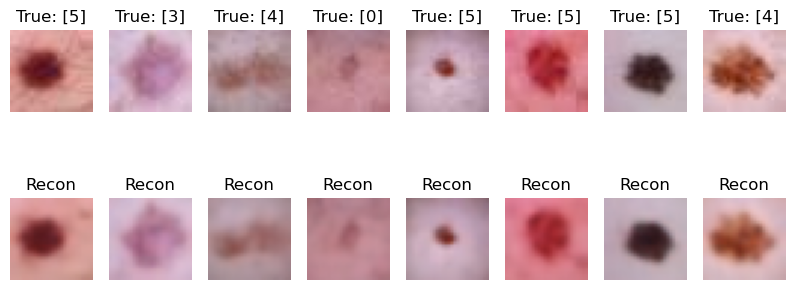

In [11]:
## Expected Output:

## 2.5: Visualize Latent Space (15 pts)

Once the model is trained, we want to inspect the **latent space** to see if it has learned a meaningful organization of the data. One way to do this is to take a bunch of images, encode them to get their latent vectors (specifically, we can use the mean $\mu$ as the representation for each image), and then visualize these vectors in 2D. Since our latent space might be higher-dimensional (e.g. 16D), we will use **UMAP** (Uniform Manifold Approximation and Projection) to reduce the dimensionality to 2 for visualization. UMAP often preserves local and global structure of the data better than t-SNE or PCA for many cases. 
**Steps:**
1. Use the trained encoder to compute $\mu$ for each image in the test set (concatenate all these latent vectors).
2. Use UMAP to transform the collection of latent vectors into 2D.
3. Create a scatter plot where each point is the 2D UMAP embedding of an image's latent vector, colored by its class label.

*Note:* You may need to install the UMAP library: `pip install umap-learn`. Also, ensure you have matplotlib for plotting. 

In [ ]:
# If UMAP is not installed, install it: !pip install umap-learn
import umap

encoder.eval()  # set encoder to evaluation mode
all_latents = []
all_labels = []

# Encode all test images to get their latent means
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        mu, log_var = encoder(images, labels)
        all_latents.append(mu.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Stack all batches together
all_latents = np.concatenate(all_latents, axis=0)  # shape [N_test_samples, latent_dim]
all_labels = np.concatenate(all_labels, axis=0)    # shape [N_test_samples]

# TODO
# Use UMAP to reduce latent dimensions to 2 for visualization

# Plot the 2D latent space
# TODO: create a scatter plot of latents_2d, colored by all_labels


## Bonus (Optional): Generating New Samples Conditioned on a Class (10 pts)

As a bonus exercise, you can use the trained VAE to **generate new images** of skin lesions by sampling from the latent space. Because our VAE is conditional, we can direct the generation by choosing a class label.

**What to do:**  
Pick a label (0 through 6, corresponding to one of the skin lesion categories in DermaMNIST), sample random latent vectors from the standard Normal prior $p(z) = \mathcal{N}(0,I)$, and feed them into the decoder along with the chosen label. This will produce novel images that (hopefully) resemble lesions of that class.

This part is open-ended – feel free to experiment by generating multiple samples and visualizing them.

## Part 3: Single cell RNA seq

**Introduction**

In this assignment, you will explore a single-cell RNA-seq dataset using the Scanpy library. You will perform basic preprocessing, clustering, and cell type annotation using known marker genes. The focus will be on identifying a few well-known immune cell types. Dataset: A 10x Genomics filtered feature barcode matrix (HDF5 format, e.g. filtered_feature_bc_matrix.h5) containing peripheral blood mononuclear cells (PBMCs). Before starting, install scanpy (and its dependencies) and ensure you have the dataset file.

## 3.1: scRNA‑seq data distribution (10 pts)
Single‑cell RNA‑sequencing (scRNA‑seq) data are characterized by high sparsity and overdispersion, meaning that most genes have zero or very low counts in individual cells, while a small subset shows high variability. This behavior is often modeled using count distributions such as the Poisson or, more commonly, the negative binomial distribution, which accounts for extra‑Poisson variability (overdispersion) observed in real datasets. Some of these zeros are a reflection of biological heterogeneity, but technical factors (e.g., dropout events) also contribute to the observed zeros. Understanding the underlying distribution is crucial for proper normalization, differential expression analysis, and downstream interpretation of scRNA‑seq data.

Below is a Python code snippet that simulates count data using both a Poisson and a negative binomial distribution and plots their histograms side-by-side. Complete the missing parts in the code as indicated.

In [2]:
import os
import subprocess
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [ ]:
n_genes = 100
n_cells = 1000

# For each gene, assign a random average expression (lambda)
lambdas = np.random.uniform(low=1.0, high=3.0, size=n_genes)

# TODO
# ---- Poisson Distribution Simulation ----
counts_poisson = 


# TODO
# ---- Negative Binomial Distribution Simulation ----
# Negative Binomial: We use parameters 'r' (dispersion) and 'mu' (mean).
r = 1  # dispersion parameter
p = r / (r + lambdas)

counts_nb = 



# ---- Calculate Mean and Variance for Each Gene ----
mean_poisson = counts_poisson.mean(axis=0)
var_poisson  = counts_poisson.var(axis=0)
mean_nb = counts_nb.mean(axis=0)
var_nb  = counts_nb.var(axis=0)

# ---- Visualization: Mean vs. Variance Scatter Plots ----
plt.figure(figsize=(8, 6))

# Poisson Distribution - Mean vs. Variance
plt.subplot(2, 2, 1)
plt.scatter(mean_poisson, var_poisson, color='green', alpha=0.7)
plt.plot([0, np.max(mean_poisson)], [0, np.max(mean_poisson)], 'k--', label='y = x')
plt.xlabel('Mean (Poisson)')
plt.ylabel('Variance (Poisson)')
plt.title('Poisson: Mean vs. Variance')
plt.legend()

# Negative Binomial Distribution - Mean vs. Variance
plt.subplot(2, 2, 2)
plt.scatter(mean_nb, var_nb, color='orange', alpha=0.7)
plt.plot([0, np.max(mean_nb)], [0, np.max(mean_nb)], 'k--', label='y = x')
plt.xlabel('Mean (Negative Binomial)')
plt.ylabel('Variance (Negative Binomial)')
plt.title('Negative Binomial: Mean vs. Variance')
plt.legend()

# ---- Visualization: Histogram of Counts for a Selected Gene ----
# Select one gene (e.g., gene index 10) for demonstration
gene_idx = 10

# Histogram for the selected gene (Poisson)
plt.subplot(2, 2, 3)
sns.histplot(counts_poisson[:, gene_idx], kde=True, color='green')
plt.title(f'Poisson Distribution for Gene {gene_idx} (λ = {lambdas[gene_idx]:.2f})')
plt.xlabel('Count')
plt.ylabel('Number of Cells')

# Histogram for the selected gene (Negative Binomial)
plt.subplot(2, 2, 4)
sns.histplot(counts_nb[:, gene_idx], kde=True, color='orange')
plt.title(f'Negative Binomial for Gene {gene_idx} (μ = {lambdas[gene_idx]:.2f}, r = {r})')
plt.xlabel('Count')
plt.ylabel('Number of Cells')

plt.tight_layout()
plt.show()

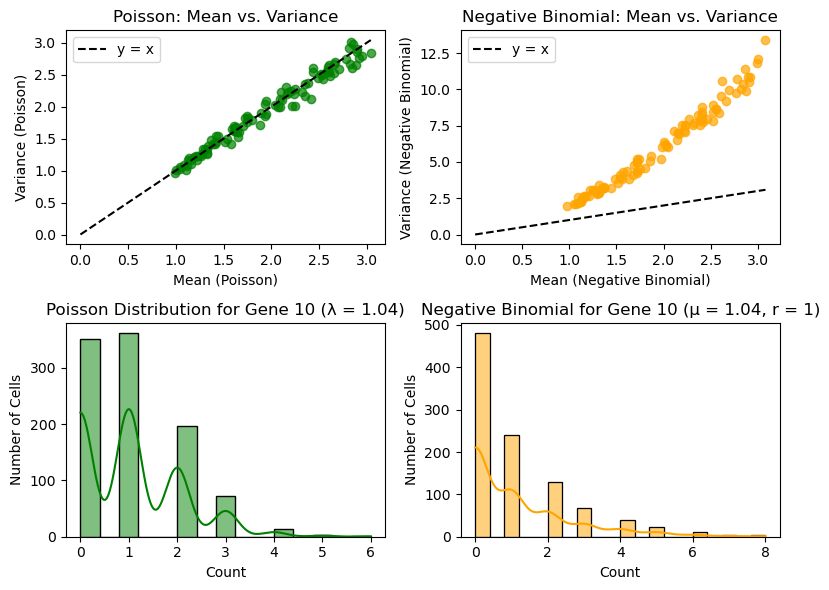

In [2]:
## Expected output: (You can test the real data, is it closer to Poisson distribution or NB distribution?)

## 3.2 Data loading and quality control (10 pts)

In this question, you'll load the single-cell dataset into Python and perform initial quality control filtering to remove low-quality cells and genes.

In [ ]:
# Download the data
!wget -O filtered_feature_bc_matrix.h5 https://figshare.com/ndownloader/files/39546196

In [4]:
# Load the 10x Genomics dataset
adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
print(adata.shape)

/gpfs/gibbs/project/gerstein/cz357/conda_envs/dqtl/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(16934, 36601)


/gpfs/gibbs/project/gerstein/cz357/conda_envs/dqtl/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


*This should print the number of cells (observations) and genes (variables) loaded. For example, `(N_cells, N_genes)`.* 

In [5]:
# TODO
# Filter cells with <200 genes and genes detected in <3 cells


*After this step, `adata.n_obs` gives the remaining number of cells. Filtering helps discard empty droplets or very low-quality cells, and genes that are nearly unobserved.* 

- **Mitochondrial gene filtering:** High **mitochondrial gene** content can indicate low-quality or dying cells. Identify mitochondrial genes (commonly those starting with "MT-") and filter out cells with a high percentage of mitochondrial reads (the threshold could be very permissive because sometimes what appears to be poor QC metrics can be driven by real biology);
- **Inspect QC metrics:** It’s often helpful to visualize QC metrics to decide on filters. For example, plot the distribution of genes per cell and fraction of mitochondrial reads:  

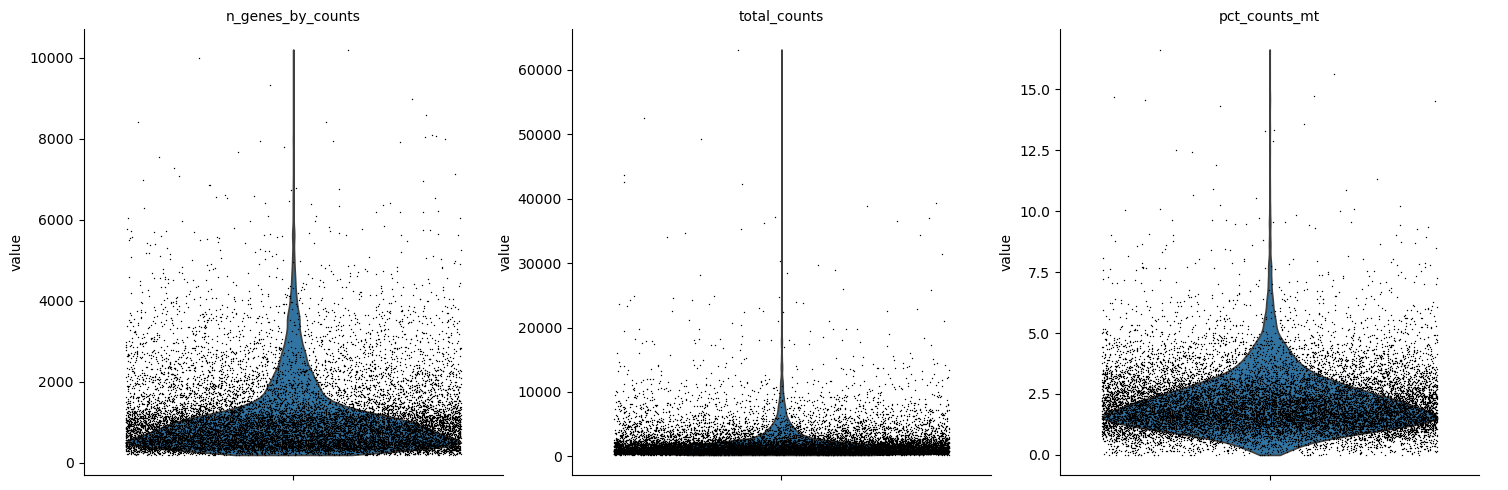

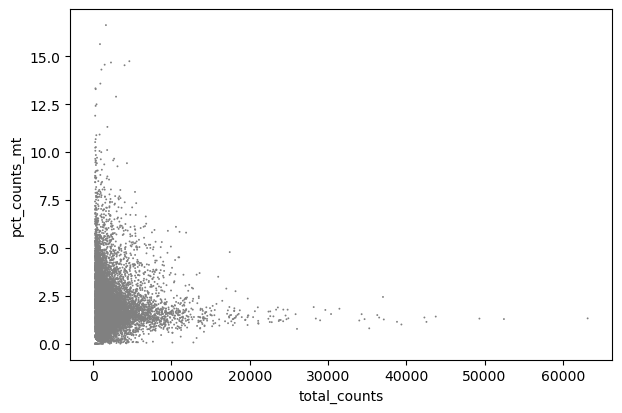

In [6]:
# TODO
# Tag mitochondrial genes:

# Calculate QC metrics (genes/cell, counts/cell, % mitochondrial):


sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

In [7]:
# Filter out cells with >10% mitochondrial genes
adata = adata[adata.obs.pct_counts_mt < 10].copy()
print(adata.shape)

(16077, 28841)


*The violin plots show the spread of key QC metrics across cells. The scatter plot of total counts vs. % mitochondrial helps spot outliers (cells with very high mitochondrial fraction or very high counts indicating potential doublets).* 

After these steps, you should have a cleaned dataset ready for normalization and analysis.

## 3.3 Normalization and PCA (10 pts)

Now that we have filtered the data, we will normalize gene counts for each cell, log-transform the data, identify highly variable genes, and perform Principal Component Analysis (PCA).

In [8]:
# TODO: Normalize total counts to 10,000 reads per cell.


*This divides each cell’s counts so that each cell has a total of 1e4 counts, mitigating differences in sequencing depth.* 

In [9]:
# TODO: Apply a log(1+x) transformation to the normalized data. This stabilizes variance and normalizes the count distribution.  

adata.raw = adata  # Save raw (normalized + log-transformed) data for future use

*The `.raw` attribute stores the log-normalized data for later (so we can still access expression values that haven’t been further processed, useful for plotting).* 

In [10]:
# TODO: Identify 2000 highly variable genes (HVGs)
# Find a subset of genes with the most variability across cells, as these drive the major differences between cell types.

print(sum(adata.var['highly_variable']), "genes selected as HVGs")

2000 genes selected as HVGs


*These genes will be used for downstream analysis (PCA, clustering) to focus on biological signal.* 

- **Scale the data:** Scale each gene to unit variance and zero mean. This step ensures that highly expressed genes do not dominate the principal components due to scale.  

In [11]:
# TODO: Scale the data to unit variance and zero mean & Clipping values at 10 helps limit the effect of extreme outliers
# This step ensures that highly expressed genes do not dominate the principal components due to scale.  


*After scaling, each gene’s expression has mean ~0 and variance ~1 across cells.* 

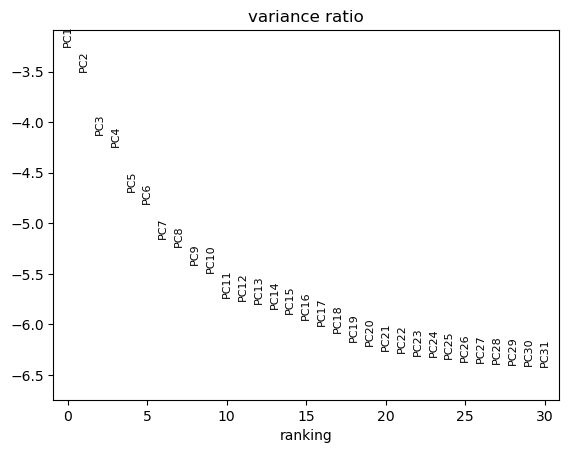

In [12]:
# TODO: Perform PCA on the normalized, log-transformed data (by default, Scanpy uses the HVGs for PCA if `adata.var['highly_variable']` is set).

sc.pl.pca_variance_ratio(adata, log=True)

*This computes the top principal components (PCs). The variance ratio plot (scree plot) shows the fraction of total variance explained by each PC on a log scale, helping decide how many PCs capture most variability.* 

## 3.4: Clustering and UMAP Visualization (5 pts)

In this question, you will construct a neighborhood graph of cells, cluster the cells, and visualize the results using UMAP. Clustering will group cells with similar expression profiles, and UMAP will project high-dimensional data into 2D for visualization.

In [13]:
# TODO: Compute neighborhood graph
# Use the PCA representation to build a k-nearest-neighbors (KNN) graph of cells. 
# This graph will be the basis for clustering and UMAP.


In [14]:
# TODO: Compute a 2D UMAP embedding of the neighbor graph.


In [15]:
# Perform Leiden clustering to group cells into discrete clusters.  
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.5) # feel free to adjust the resolution.

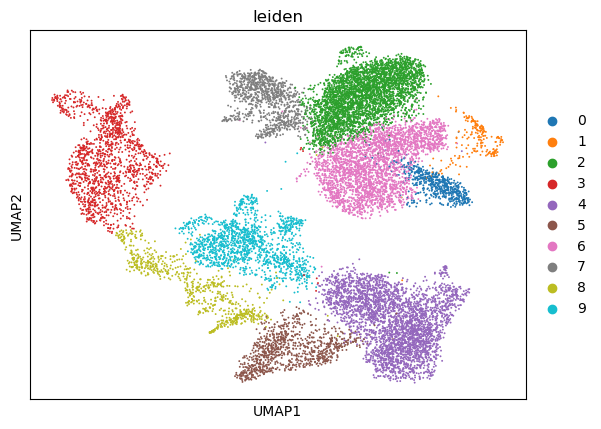

In [16]:
sc.pl.umap(adata, color=['leiden'])

Look at the UMAP plot to see how well-separated the clusters are. Are there clear distinct clusters or some that blend? You can also plot UMAP with different `color` arguments (e.g., QC metrics or top genes) to explore what might distinguish clusters

## 3.5: Cell Type Annotation with Marker Genes (20 pts)

Clustering alone gives arbitrary cluster labels (0, 1, 2, ...). In this final question, you'll use **known marker genes** to identify the biological cell types for each cluster. We focus on a few major immune cell types and a small set of marker genes for each:

- **CD14+ Monocytes:** markers **FCN1**, **LYZ**  
- **CD8+ T cells:** markers **CD8A**, **GZMB**, **GZMH**
- **CD4+ T cells:** marker **CD4, IL7R** 
- **Transitional B:** marker **MME**, **CD38**, **CD24**, **ACSM3**
- **B1 B cells:** marker **MS4A1**

And feel free to explore it and add more marker genes here!

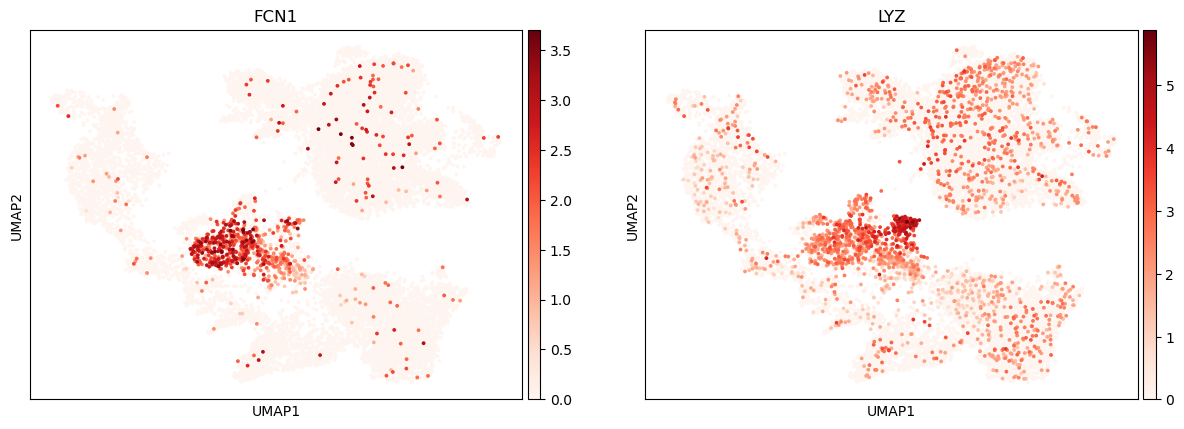

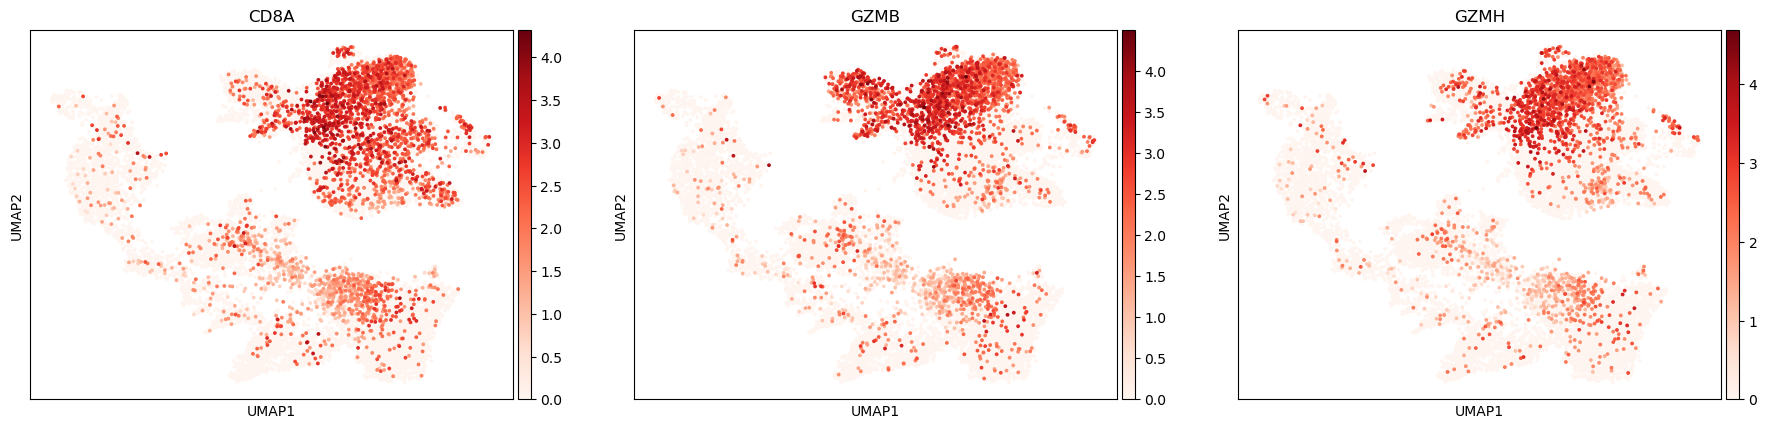

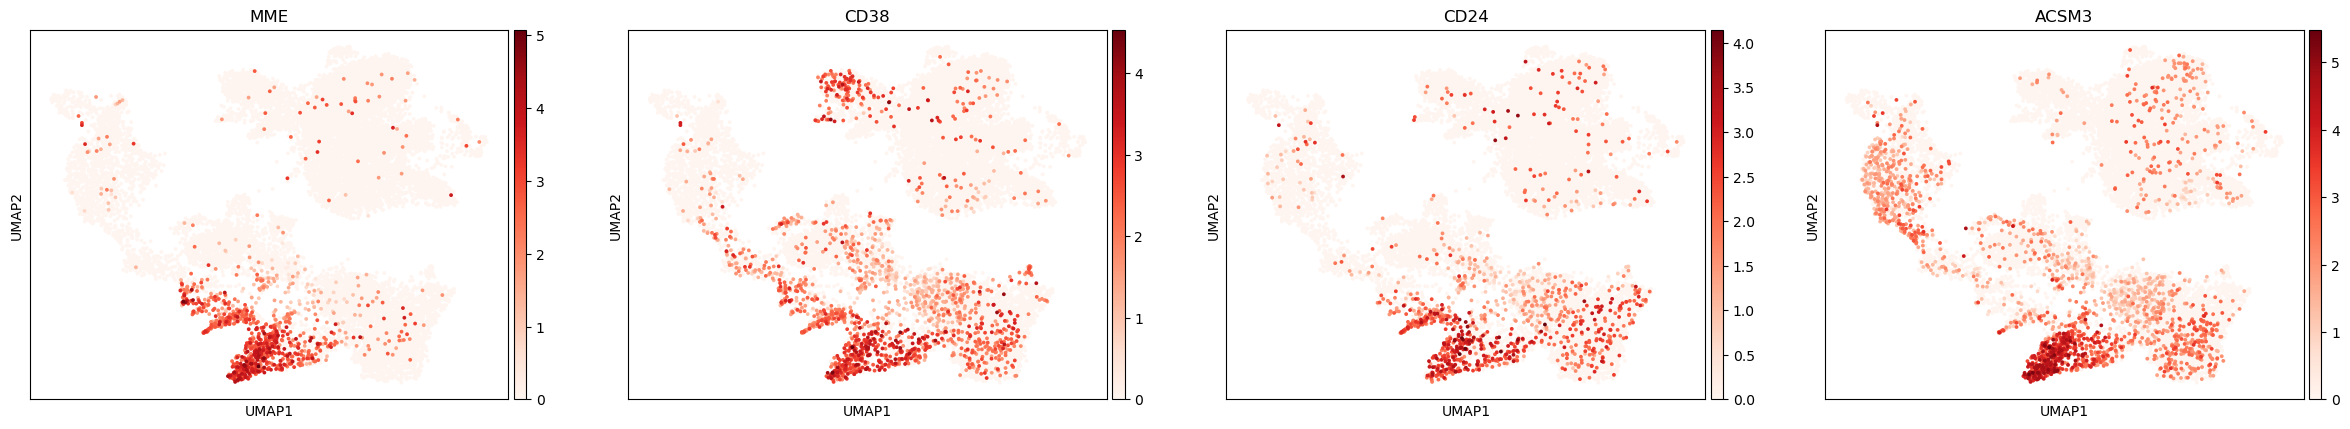

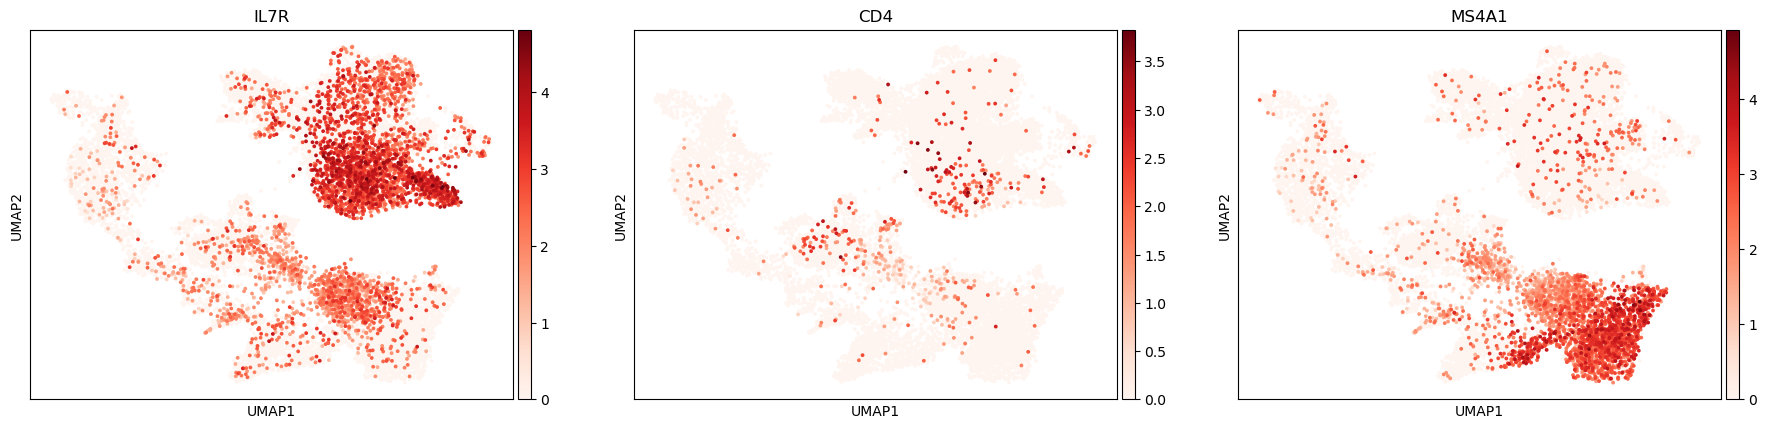

In [25]:
# Example UMAP plots for some marker genes.
sc.pl.umap(adata, color=["FCN1", "LYZ"], color_map="Reds", size=30)
sc.pl.umap(adata, color=["CD8A", "GZMB", "GZMH"], color_map="Reds", size=30)
sc.pl.umap(adata, color=["MME", "CD38", "CD24", "ACSM3"], color_map="Reds", size=30)
sc.pl.umap(adata, color=['IL7R', 'CD4', 'MS4A1'], color_map="Reds", size=30)

**Assign cluster identities:** Based on the marker gene patterns, assign a cell type label to each cluster. For example, if cluster “5” has high **CD14** and **LYZ**, label it *“CD14+ Monocytes”*. Create a new column in `adata.obs` with these annotations and provide a UMAP visualization of your final cell annotations.

*Not all clusters may correspond to the cell types above; smaller clusters might be other cell types (e.g., dendritic cells or platelets) which you can label as “Other” or leave unnamed. You just need to focus on labeling the main clusters with the provided cell types.* 

**(Optional)** *Identify additional marker genes:* You can let Scanpy find marker genes for each cluster using:  
```python
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=5)
```  
This will show the top genes enriched in each cluster, which should include the known markers above and possibly reveal other distinguishing genes. This optional step can further validate your annotations or highlight clusters corresponding to cell types beyond the five focused ones.